# Training the Semi-Supervised GAN for Melanoma Image Classification

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import PIL
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from os import listdir
from os.path import join
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

print(device)

cpu


In [3]:
#set path to data folders
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))

transform = transforms.ToTensor()

## Setting up an Image Pipeline

Preparing a data pipeline that handles the pre-processing and augmentation of the labele dataset. Dataset classes are custom classes inheriting from the abstract Pytorch class torch.utils.data.Dataset, overiding the `__len__` and `__getitem__` methods in order to be able toget the size of the dataset via `len(dataset)` and access each datasample as `dataset[index]`. If no transform specified, datasets returning images in the form of objects of type `PIL.PngImagePlugin.PngImageFile`. Turn the images into Pytorch tensors via the Dataset class transform argument.

### Unlabeled Data Set

In [4]:
def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

class UnlabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Transform to be applied on an image.
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [5]:
unlabeled_data_path = os.path.join(path, parent, 'Data/unlabeled/')
unlabeled_set = UnlabeledDataset(dir_path= unlabeled_data_path, transform=transform)

print('Number of images in the unlabeled set: ', len(unlabeled_set))

Number of images in the unlabeled set:  7018


### Labeled Data Set

Benign images are named *\_0.jpg*, whereas images of melanoma have filenames ending with *\_1.jpg*. The __getitem__ method returns the image with a label. 

In [6]:
class LabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
                
            If not transform PIL.PngImagePlugin.PngImageFile    
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
            
        label = int(img_name[-5])

        return image, label
    

In [7]:
labeled_data_path = os.path.join(path, parent, 'Data/labeled/')
labeled_set = LabeledDataset(dir_path= labeled_data_path, transform=transform)

print('Number of images in the labeled set: ', len(labeled_set))

test_data_path = os.path.join(path, parent, 'Data/test/')

Number of images in the labeled set:  200


### DataLoaders

`torch.utils.data.DataLoader` takes care of splitting the data into minibatches of a given size, shuffling it if needed, and loading it in parallel by using multiprocessing workers.

In [13]:
unlabeled_loader = DataLoader(unlabeled_set, 
                              batch_size=16, 
                              shuffle=True, 
                              num_workers=0)

labeled_loader = DataLoader(labeled_set, 
                            batch_size=16, 
                            shuffle=True, 
                            num_workers=0)

### Data Augmentation

With the `torchvision.transforms` package transformations applied at random with a chosen probability, augment the unlabeled and labeled data sets making sure that the augmented dataset follows the same distribution as the original.

In [8]:
def get_norm_parameters(dataset): 
    """ Function computing the mean and std for each chanel across the dataset 
        after stacking the tensors of the dataset """

    if len(dataset[0]) > 2:    
        imgs = torch.stack([img_tensor for img_tensor in dataset], dim=3)
        
    else: 
        imgs = torch.stack([img_tensor for img_tensor, _ in dataset], dim=3)

    #keep the RBG channels and merge the rest of the dims, 3x32x32 is transformed into 3x1024 
    mean = imgs.view(3, -1).mean(dim=1)
    std  = imgs.view(3, -1).std(dim=1)
    
    return mean, std

In [9]:
unlabeled_mean, unlabeled_std = get_norm_parameters(unlabeled_set)
labeled_mean, labeled_std     = get_norm_parameters(labeled_set)

print("unlabeled data set mean {} and std {}".format(unlabeled_mean, unlabeled_std))
print("labeled data set mean {} and std {}".format(labeled_mean, labeled_std))

#NB: The mean and std of the augmented data should be the same as the labeled!?

unlabeled data set mean tensor([0.7722, 0.5286, 0.5501]) and std tensor([0.1399, 0.1602, 0.1772])
labeled data set mean tensor([0.7441, 0.5331, 0.5548]) and std tensor([0.1464, 0.1557, 0.1735])


In [10]:
#augment the labeled data by applying randomly a list of transformations with given probability
augmentation = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation(0,360)])
                                    
unlabeled_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(mean = unlabeled_mean,
                                                               std = unlabeled_std)])                                   
labeled_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(mean = labeled_mean,
                                                               std = labeled_std)])                                      

In [11]:
unlabeled_set = UnlabeledDataset(unlabeled_data_path, 
                                 transform=transforms.Compose([augmentation, unlabeled_transform]))
labeled_set = LabeledDataset(labeled_data_path,     
                             transform=transforms.Compose([augmentation, labeled_transform]))
                             
test_set = LabeledDataset(test_data_path,
                          transform=transforms.Compose([transforms.ToTensor()]))                            

In [12]:
batch_size = 64
num_workers = 0

unlabeled_loader = DataLoader(unlabeled_set, 
                              batch_size=batch_size, 
                              num_workers=num_workers,
                              shuffle=True)

labeled_loader = DataLoader(labeled_set, 
                            batch_size=batch_size, 
                            num_workers=num_workers,
                            shuffle=True)

test_loader = DataLoader(dataset = test_set,
                         batch_size = batch_size,
                         num_workers = num_workers,
                         shuffle=True)

## Analysis of semi-supervised learning strategy

In [81]:
def convert_0_1(imgs, nc=3):
    
    imgs = imgs.view(imgs.size(0), -1)
    imgs -= imgs.min(1, keepdim=True)[0]
    imgs /= imgs.max(1, keepdim=True)[0]
    imgs = imgs.view(batch_size, nc , 32, 32)
    
    return imgs

In [34]:
# Number of channels of training images
nc = 3

# Latent vector dimensions  latent vector, i.e. size of generator input
z_dim = 20

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# batch of latent vectors used to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

num_epochs = 20

In [29]:
def weights_init(m, mean=0.0, std=0.2):
    
    """ Randomly initialize the weights of the Generator and Discriminator
        to normaly distributed with mean of 0 and std of 0.2 """
    
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean, std)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, std)
        nn.init.constant_(m.bias.data, 0)

In [19]:
os.getcwd()

'/Users/elliemcintosh/Documents/Python/ManningBooks_LiveProjects/MelanomaDetection/Code'

In [20]:
def create_dir(directory):
    
    """Creates a directory if it does not already exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)
   

In [21]:
data_root = os.path.join(path, parent, 'Data/')
gener_img_dir = "generated_Melanoma"
check_pt_dir = "/models_wts/Melanoma_SGAN/"

create_dir(data_root + gener_img_dir)
create_dir(path + check_pt_dir)

In [22]:
def checkpoint(epoch, G, D, optimizerG, optimizerD, lossG, lossD):
    """
    Saves the parameters of the generator G and discriminator D
    and other checkpoints for finetuning, Adam optimizer has internal
    parameters which would be reset to default values
    """
    Melanoma_SGAN_path = os.getcwd() + check_pt_dir + 'SGAN.pkl'  
    # serializes the object with python pickle
    torch.save({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(), #
            'optimizerD_state_dict': optimizerD.state_dict(),
            'lossG': lossG,
            'lossD': lossD
            }, Melanoma_SGAN_path)
    
def load_checkpoint(model, check_pt_name):
    # unpickling to deserialize the saved object with torch.load; 
    model.load_state_dict(torch.load(os.getcwd() + check_pt_dir + check_pt_name))

In [24]:
best_model_path = os.path.join(os.getcwd() + check_pt_dir + "best_discriminator_wts.pkl")

In [64]:
def binary_predict(x):
    
    """ Transoforms the 2 neurons output of the last fully
        connected layer into a binary, real vs fake output
        
           D(x)= Z(x)/Z(x)+1 where Z(x)=Sum(exp[l(x)])
           
        where x is an input image, and l are the logits from 
        the final layer of the classifier. The sum over logits 
        goes from 1 to 2 (number of classes). The value of D(x)
        is close to 1 when a strong prediction has been made for 
        one of the 2 (real) classes, and close to zero when the 
        2 logits' values are small."""   
    
    # .sum(dim) Returns the sum of each row of the input tensor in the given dimension dim
    # dim = -1 means the last dimension
    Z = torch.exp(x).sum(dim = -1)
    D = Z/(Z + 1.0)
    
    if torch.isnan(D).sum() > 0:
        print("binary real vs fake prediction contains na: ", D)
    
    return D

In [65]:
class Discriminator(nn.Module):
    
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=2, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn1 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4, ndf*2, kernel_size=4, stride=1, padding=0, bias=False)
        
        # fully connected layer with 2 output classes
        self.fc1     = nn.Linear(ndf*2, 2, bias=True) 
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        x = self.conv1(input)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv2(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv3(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv4(x)
        x = x.view(-1, ndf*2)
        
        x = self.fc1(x)
        
        binary_out = binary_predict(x)
        class_out  = self.softmax(x.squeeze())   
        
        return binary_out, class_out
        

In [66]:
#create and initialize the generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [70]:
# Initialize the loss functions
bce_loss = nn.BCELoss()
cce_loss = nn.CrossEntropyLoss()

In [72]:
loss_supervised = cce_loss(labeled_class, labels)
print(loss_supervised)

tensor(0.8397, grad_fn=<NllLossBackward>)


In [73]:
#Set up Adam optimizers for the Generator and Discriminator
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas=(beta1, 0.999))

In [75]:
def test(model, device, data_loader):
    
    """Evaluates the model's performance on test dataset"""

    test_loss = 0
    correct = 0

    test_acc = []

    model.eval()
    with torch.no_grad():
        
        for imgs, labels in data_loader:
            
            
            binary_output, class_output = netD(imgs.to(device))
        
            test_loss += cce_loss(class_output, labels.to(device)).item()
            
            pred = class_output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.to(device).data.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(data_loader.dataset), 100. * correct/len(data_loader.dataset)))
           
    #return test_loss, 100.*correct/len(data_loader.dataset)
            
    avg_loss = np.round(test_loss/len(data_loader.dataset), 4)
    accuracy = 100. * correct/len(data_loader.dataset)  
    
    print("Test Avg Loss: {:.4f}, Discriminator Test Accuracy: {:.2f} %".format(avg_loss, accuracy))
        
    return avg_loss, accuracy

In [ ]:
num_epochs = 37
num_iter = np.ceil(len(labeled_loader.dataset)/batch_size).astype(int)
print_every = 3

fixed_fake_imgs =[]

# Lists to keep track of progress
G_losses = []
D_losses = []

epoch_losses = []
train_loss = []
train_cntr = []

test_losses =[]
test_accuracies =[]

fixed_fake_list = []

best_model_wts = torch.save(netD.state_dict(), "best_discriminator_wts")
best_acc = 0.0

displ_imgs = batch_size

for epoch in range(num_epochs):
            
    #for each iteration
    for i in range(num_iter):
        
        real_labeled_imgs, real_class_labels = next(iter(labeled_loader))
        
        real_unlabeled_imgs = next(iter(unlabeled_loader))
        num_imgs = real_labeled_imgs.size()[0]
        
        real_labeled_imgs.to(device)
        real_class_labels.to(device)
        
        real_unlabeled_imgs.to(device)  
        
        # make binary labeles for the real unlabeled images and for the fake generated images               
        real_binary_labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)
        fake_binary_labels = torch.full((num_imgs,), fake_label, dtype=torch.float, device = device)
               
        ###############################################################
        #                                                             #
        #                      Train the Discriminator                #
        #                                                             #
        ###############################################################
        
        netD.train()
        optimizerD.zero_grad()
            
        ################### On Unlabeled Images #######################
        # rescale input images from [0, 1] to [-1, 1]
        real_unlabeled_imgs = real_unlabeled_imgs * 2 - 1
        
        binary_real, _ = netD(real_unlabeled_imgs)
        
        binary_real_loss = 0.5 * bce_loss(binary_real, real_binary_labels)
        
        binary_real_loss.backward()      
        
        ################### On Generated Images ####################### 
        
        noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)
        
        fake_imgs = netG(noise)
        
        binary_fake, _ = netD(fake_imgs.detach()) 
        
        binary_fake_loss = 0.5 * bce_loss(binary_fake, fake_binary_labels)
        
        binary_fake_loss.backward()
        
        loss_unsupervised = binary_real_loss + binary_fake_loss
                
        ####################### On Labeled Images ######################
        # rescale input images from [0, 1] to [-1, 1]
        real_labeled_imgs = real_labeled_imgs * 2 - 1
        
        _, class_real  = netD(real_labeled_imgs)
        
        # supervised loss
        loss_supervised = cce_loss(class_real, real_class_labels)
        
        train_loss.append(loss_supervised.item())
        train_cntr.append((i+1)*num_imgs + epoch * len(labeled_loader.dataset))
  
        loss_supervised.backward() #retain_graph=True
        
        ###################### update Discriminator ####################

        lossD = loss_supervised + loss_unsupervised
        
        train_loss.append(lossD.item())
        train_cntr.append((i+1)*num_imgs + epoch * len(labeled_loader.dataset))
  
        #lossD.backward(retain_graph=True)
        
        optimizerD.step()
        
        ###############################################################
        #                                                             #
        #                      Train the Generator                    #
        #                                                             #
        ###############################################################
        
        netG.train()
        optimizerG.zero_grad()
        
        binary_fake, _ = netD(fake_imgs)
        
        lossG = bce_loss(binary_fake, real_binary_labels)
        
        lossG.backward()
        
        optimizerG.step()      
                
        ###############################################################
        #                                                             #
        #                    Output training stats                    #
        #                                                             #
        ###############################################################
        
        # Calculate discriminator accuracy
        pred_labels = np.concatenate([class_real.data.cpu().numpy(), ], axis=0)
        ground_truth = np.concatenate([real_class_labels.data.cpu().numpy(), ], axis=0)
        
        # get the indices of the maximum values along the 2 class dim 1
        D_acc = np.mean(np.argmax(pred_labels, axis=1) == ground_truth)
        # print out training stats every chosen number of batches
        if i % print_every == 0:
            
            print('\nEpoch {}/{}  Batch {}/{}'.format(epoch +1, num_epochs, i, len(labeled_loader)))
            print('-'*30)
            print('Classifier Loss: {:.4f}, Generator Loss: {:.4f}, Training Accuracy: {:.1f} %'.format(loss_supervised.item(), lossG.item(), 100*D_acc))
            print()
            
        # save losses for plotting
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())   
    
    ############################ after each epoch  #########################
    
    #evaluate how the generator is doing
    #netG.eval()
    #with torch.no_grad():
        #rescale from [-1, 1] back to [0, 1]
        #fixed_fake = (netG(fixed_noise).detach().cpu()+1.0)/2.0
        #image_grid = torchvision.utils.make_grid(convert_0_1(fixed_fake), nrow=16)
        
        #print("Epoch ", epoch +1)
        #plt.figure(figsize=(20,10))
        #plt.imshow(image_grid.permute(1, 2, 0))
        #plt.axis("off")
        #plt.pause(0.05)
        
        #fixed_fake_list.append(torchvision.utils.make_grid(convert_0_1(fixed_fake.detach().cpu()), padding=2, normalize=True, nrow=16))
        
        #torchvision.utils.save_image(fixed_fake.data[:], 
                                     #data_root + gener_img_dir + "/fixed_fake_%d.jpg" % (epoch+1), 
                                     #nrow=16, normalize=True)
    
    #netG.train()
    
    # evaluate how the Discriminator is doing on training and testing datasets
    epoch_losses.append(train_loss[-1])
    
    print("\nEpoch: {}, Loss {:.4f}, Discriminator Avg Training Loss {:.4f}".format(epoch+1, epoch_losses[-1], sum(epoch_losses)/len(epoch_losses)))
    
    test_loss, test_accuracy = test(netD, device, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        best_discriminator_wts = torch.save(netD.state_dict(), os.getcwd() + check_pt_dir + "best_discriminator_wts.pkl")
    
    print("Discriminator best test accuracy {:.2f} %".format(best_acc))
        
    checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses)
               

Text(0.5, 0, 'Iterations')

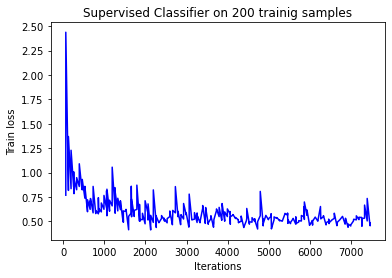

In [77]:
# Plot Discriminator as a supervised classifier training performance
plt.plot(train_cntr, train_loss, color='blue')
plt.title("Supervised Classifier on 200 trainig samples")
plt.ylabel('Train loss')
plt.xlabel('Iterations')

In [ ]:
plt.plot(range(num_epochs), np.array(epoch_losses))
plt.ylabel('Train loss')
plt.xlabel('epochs')
plt.title("Discriminator train and test performance")
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('Test loss', color=color)
ax1.plot(range(num_epochs), np.array(test_losses), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Test accuracy', color=color)  
ax2.plot(range(num_epochs), np.array(test_accuracies), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [ ]:
# load best model weights
netD.load_state_dict(torch.load(best_model_path))

print("\nBest model on the test set: ")
test(netD, device, test_loader) 